In [17]:
#!pip install torchsummary

In [18]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary    

%matplotlib inline

In [19]:
data_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [20]:
# printing the disease names
print(diseases)

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [21]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 38


In [22]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [23]:
plants1 = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants1:
        plants1.append(plant.split('___')[0])
print(plants1)

['Tomato', 'Grape', 'Orange', 'Soybean', 'Squash', 'Potato', 'Corn_(maize)', 'Strawberry', 'Peach', 'Apple', 'Blueberry', 'Cherry_(including_sour)', 'Pepper,_bell', 'Raspberry']


In [24]:
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Tomato', 'Grape', 'Orange', 'Soybean', 'Squash', 'Potato', 'Corn_(maize)', 'Strawberry', 'Peach', 'Apple', 'Blueberry', 'Cherry_(including_sour)', 'Pepper,_bell', 'Raspberry']


In [25]:
# datasets for validation and training
#train = ImageFolder(train_dir, transform=transforms.ToTensor())
#valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) 

In [26]:
#img, label = train[0]
#print(img.shape, label)

In [27]:
#type(train)

In [28]:
#train.class_to_idx

In [29]:
from torch.utils.data import Dataset

In [30]:
class CustomDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.classes, self.class_to_idx = self._find_classes()
        self.samples = self._make_dataset()
        self.categories_with_idx = self._get_categories()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        image_path, target, class_name = self.samples[index]
        image = Image.open(image_path)

        if self.transform is not None:
            image = self.transform(image)
            
        plant_category = class_name.split('___')[0]
        all_categories = self._get_categories()
        category_idx = all_categories[plant_category]
        
        return image, target, category_idx

    def _get_categories(self):
        categories = sorted(os.listdir(self.root_folder))
        plants = []
        for plant in categories:
            if plant.split('___')[0] not in plants:
                plants.append(plant.split('___')[0])
        category_to_idx = {category_name: i for i, category_name in enumerate(plants)}
        return category_to_idx
    
    def _find_classes(self):
        classes = sorted(os.listdir(self.root_folder))
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def _make_dataset(self):
        samples = []
        for class_name in self.classes:
            class_dir = os.path.join(self.root_folder, class_name)
            if not os.path.isdir(class_dir):
                continue

            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                if os.path.isfile(image_path):
                    item = (image_path, self.class_to_idx[class_name], class_name)
                    samples.append(item)

        return samples


In [31]:
plants = []
categories = sorted(os.listdir(train_dir))
for plant in categories:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
category_to_idx = {category_name: i for i, category_name in enumerate(plants)}
category_to_idx

{'Apple': 0,
 'Blueberry': 1,
 'Cherry_(including_sour)': 2,
 'Corn_(maize)': 3,
 'Grape': 4,
 'Orange': 5,
 'Peach': 6,
 'Pepper,_bell': 7,
 'Potato': 8,
 'Raspberry': 9,
 'Soybean': 10,
 'Squash': 11,
 'Strawberry': 12,
 'Tomato': 13}

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torchvision import transforms, datasets

# Define the Multi-Level ResNet Model
class MultiLevelResNet(nn.Module):
    def __init__(self):
        super(MultiLevelResNet, self).__init__()
        self.resnet = resnet50(pretrained=True)
        self.fc_category = nn.Linear(1000, 14)
        self.fc_disease = nn.Linear(1000, 38)

    def forward(self, x):
        features = self.resnet(x)
        category_output = self.fc_category(features)
        disease_output = self.fc_disease(features)
        return category_output, disease_output

In [32]:
# Set hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 10

In [33]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [34]:
# datasets for validation and training
train = CustomDataset(train_dir, transform=transforms.ToTensor())
valid = CustomDataset(valid_dir, transform=transforms.ToTensor()) 

In [35]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

In [36]:
img, label, category = train[0]
print(img.shape, label, category)

torch.Size([3, 256, 256]) 0 0


In [37]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [38]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

In [39]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [40]:
device = get_default_device()
device

device(type='cuda')

In [41]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [42]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [43]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


In [44]:

# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases, num_category):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier_diseases = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        self.classifier_category = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_category))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        resnet_out = self.res2(out) + out
        disease_out = self.classifier_diseases(resnet_out)
        category_out = self.classifier_category(resnet_out)
        return (disease_out, category_out)  

In [45]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes), 14), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [46]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [47]:
# for training
'''
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    '''

"\n@torch.no_grad()\ndef evaluate(model, val_loader):\n    model.eval()\n    outputs = [model.validation_step(batch) for batch in val_loader]\n    return model.validation_epoch_end(outputs)\n\n\ndef get_lr(optimizer):\n    for param_group in optimizer.param_groups:\n        return param_group['lr']\n    \n\ndef fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,\n                grad_clip=None, opt_func=torch.optim.SGD):\n    torch.cuda.empty_cache()\n    history = []\n    \n    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)\n    # scheduler for one cycle learniing rate\n    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))\n    \n    \n    for epoch in range(epochs):\n        # Training\n        model.train()\n        train_losses = []\n        lrs = []\n        for batch in train_loader:\n            loss = model.training_step(batch)\n            train_losses.append(l

%%time
history = [evaluate(model, valid_dl)]
history

In [48]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

In [49]:

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [50]:
for epoch in range(1, 2 + 1):
    model.train()
    for images, labels, category in train_dl:
        images = images.to(device)
        labels = labels.to(device)
        category = category.to(device)
        
        optimizer.zero_grad()
        disease_output, category_output  = model(images)
        #print(disease_output, category_output)
        #break
        disease_loss = criterion(disease_output, labels)
        plant_loss = criterion(category_output, category)

        loss = disease_loss + plant_loss

        loss.backward()
        optimizer.step()

    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels, category in valid_dl:
            images = images.to(device)
            labels = labels.to(device)
            category = category.to(device)
            
            disease_output, category_output = model(images)

            _, disease_predicted = torch.max(disease_output, 1)
            _, plant_predicted = torch.max(category_output, 1)

            total_correct += (disease_predicted == labels).sum().item() + (plant_predicted == category).sum().item()
            total_samples += labels.size(0) * 2

    accuracy = 100.0 * total_correct / total_samples
    print(f"Epoch: {epoch}, Accuracy: {accuracy:.2f}%")


Epoch: 1, Accuracy: 93.31%
Epoch: 2, Accuracy: 96.01%


In [52]:
# predicting first image


In [54]:
test_dir = "../input/new-plant-diseases-dataset/test"
test = CustomDataset(test_dir, transform=transforms.ToTensor())

In [55]:
test_images = sorted(os.listdir(test_dir + '/test')) # since images in test folder are in alphabetical order
test_images

['AppleCedarRust1.JPG',
 'AppleCedarRust2.JPG',
 'AppleCedarRust3.JPG',
 'AppleCedarRust4.JPG',
 'AppleScab1.JPG',
 'AppleScab2.JPG',
 'AppleScab3.JPG',
 'CornCommonRust1.JPG',
 'CornCommonRust2.JPG',
 'CornCommonRust3.JPG',
 'PotatoEarlyBlight1.JPG',
 'PotatoEarlyBlight2.JPG',
 'PotatoEarlyBlight3.JPG',
 'PotatoEarlyBlight4.JPG',
 'PotatoEarlyBlight5.JPG',
 'PotatoHealthy1.JPG',
 'PotatoHealthy2.JPG',
 'TomatoEarlyBlight1.JPG',
 'TomatoEarlyBlight2.JPG',
 'TomatoEarlyBlight3.JPG',
 'TomatoEarlyBlight4.JPG',
 'TomatoEarlyBlight5.JPG',
 'TomatoEarlyBlight6.JPG',
 'TomatoHealthy1.JPG',
 'TomatoHealthy2.JPG',
 'TomatoHealthy3.JPG',
 'TomatoHealthy4.JPG',
 'TomatoYellowCurlVirus1.JPG',
 'TomatoYellowCurlVirus2.JPG',
 'TomatoYellowCurlVirus3.JPG',
 'TomatoYellowCurlVirus4.JPG',
 'TomatoYellowCurlVirus5.JPG',
 'TomatoYellowCurlVirus6.JPG']

tensor([[0.0118, 0.0118, 0.0118,  ..., 0.0157, 0.0235, 0.0235],
        [0.0118, 0.0118, 0.0118,  ..., 0.0157, 0.0235, 0.0235],
        [0.0118, 0.0118, 0.0118,  ..., 0.0157, 0.0157, 0.0157],
        ...,
        [0.2824, 0.3137, 0.3255,  ..., 0.0118, 0.0118, 0.0118],
        [0.3569, 0.3647, 0.3490,  ..., 0.0118, 0.0118, 0.0118],
        [0.3373, 0.3725, 0.3961,  ..., 0.0118, 0.0118, 0.0118]]) 0 0
Label: 0


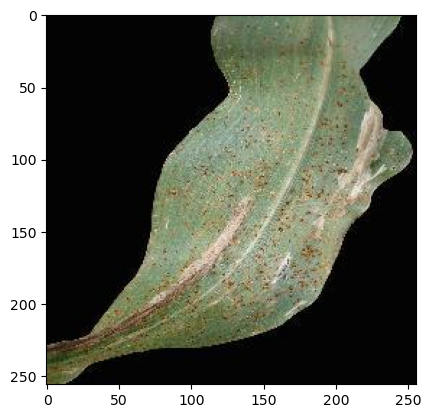

In [98]:
# predicting first image
img, label, category = test[12]
print(img[0], label, category)
plt.imshow(img.permute(1, 2, 0))
print('Label:', label)

In [93]:
img, label, category = test[12]
xb = to_device(img.unsqueeze(0), device)

In [94]:
#prediction
disease, category = model(xb)

In [95]:
_,p_disease = torch.max(disease, dim=1)
train.classes[p_disease[0].item()]

'Corn_(maize)___Common_rust_'

In [96]:
_, p_category = torch.max(category, dim=1)
print(p_category[0].item())
train.categories_with_idx

3


{'Apple': 0,
 'Blueberry': 1,
 'Cherry_(including_sour)': 2,
 'Corn_(maize)': 3,
 'Grape': 4,
 'Orange': 5,
 'Peach': 6,
 'Pepper,_bell': 7,
 'Potato': 8,
 'Raspberry': 9,
 'Soybean': 10,
 'Squash': 11,
 'Strawberry': 12,
 'Tomato': 13}